# <u>Chapter 3</u>: Classifying Topics of Newsgroup Posts

Businesses deal with many unstructured texts, such as news posts, support tickets, or customer reviews. Failing to glean this data efficiently can lead to missed opportunities or, even worse, angry customers. So again, an automated system that can process a vast amount of data is a more scalable solution than manual scanning.

In this exercise, we focus on the problem of `topic classification`, intending to assign a label (or topic) to a piece of text. For this task, we use the [20 newsgroups dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) available in the _scikit-learn_ module, which comprises around 18,000 news posts on 20 topics.

We implement a topic classifier from scratch and present various techniques related to dimensionality reduction and text mining.

You need a Google account to download: [GoogleNews-vectors-negative300.bin.gz](https://code.google.com/archive/p/word2vec/)

Then, place the file under: _./data_

In [11]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'sklearn', 'pandas', 'numpy', 'seaborn', 'gensim', 'fasttext'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

## Exploratory data analysis

A primary concern during EDA is to verify that the dataset is appropriately formatted before resorting to the subsequent analysis. Other times, we need to transform or exclude part of the data. Having an imbalanced dataset where one class monopolizes the whole corpus is also a source of concern.

In the following code, we load and extract some basic statistics from the _fetch_20newsgroups_ corpus, starting with the total number of samples.

In [12]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

# Load the news data and print the names of the categories.
news = fetch_20newsgroups(subset='all')

# Print various information about the data.
print("Number of articles: " + str(len(news.data)))


Number of articles: 18846


Let’s get the number of the different news post categories.

In [13]:
print("Number of different categories: " + str(len(news.target_names)))

Number of different categories: 20


Now, we obtain the topic names of all categories.

In [14]:
print(news.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


The output suggests that the posts deal with diverse topics, including _technology_, _politics_, _religion_, and 
_sports_. Next, we print the content of one sample.

In [15]:
print("\n".join(news.data[6].split("\n")[:]))

From: lpa8921@tamuts.tamu.edu (Louis Paul Adams)
Subject: Re: Number for Applied Engineering
Organization: Texas A&M University, College Station
Lines: 9
NNTP-Posting-Host: tamuts.tamu.edu

>Anyone have a phone number for Applied Engineering so I can give them
>a call?


AE is in Dallas...try 214/241-6060 or 214/241-0055.  Tech support may be on
their own line, but one of these should get you started.

Good luck!




In the following code snippet, we create and show a pie chart; each slice represents the percentage of one of the news categories in the corpus.

([<matplotlib.patches.Wedge at 0x16d62078130>,
 [Text(-0.1823390344437654, 1.0847822253881723, 'alt.atheism'),
  Text(-0.5242380015331813, 0.9670442170596422, 'comp.graphics'),
  Text(-0.8021215165432405, 0.752729083202165, 'comp.os.ms-windows.misc'),
  Text(-0.9968998151638248, 0.4649631797533352, 'comp.sys.ibm.pc.hardware'),
  Text(-1.093125893449529, 0.12278347230050732, 'comp.sys.mac.hardware'),
  Text(-1.0864944398876528, -0.17184246300962938, 'comp.windows.x'),
  Text(-1.0013486397090283, -0.45530308779194417, 'misc.forsale'),
  Text(-0.7996074805859845, -0.7553991507745655, 'rec.autos'),
  Text(-0.5423599974411815, -0.9569982409469737, 'rec.motorcycles'),
  Text(-0.23615868809794194, -1.0743505359219863, 'rec.sport.baseball'),
  Text(0.12588077877732232, -1.0927735490642216, 'rec.sport.hockey'),
  Text(0.4729249455167271, -0.9931475197109444, 'sci.crypt'),
  Text(0.7667843535344453, -0.7886962375812141, 'sci.electronics'),
  Text(0.9793485130956973, -0.5008757230064629, 'sci.med

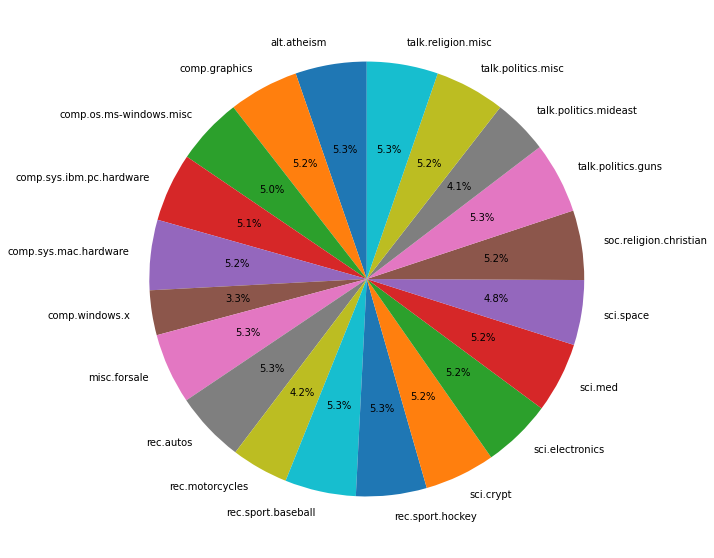

In [16]:
import matplotlib.pyplot as plt

# Keep track of the number of samples per category.
samples_per_category = {}

# Iterate over all data.
for i in range(len(news.data)):
	# Get the category for the specific sample.
	category = news.target_names[news.target[i]]
	# Increase the category index by one.
	if category in samples_per_category:
		samples_per_category[category] += 1
	else:
		samples_per_category[category] = 1

# Create and show the distribution pie chart.
slices = []

# Obtain the slices of the pie.
for key in samples_per_category:
	slices.append(samples_per_category[key])

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(slices, labels=news.target_names, autopct='%1.1f%%', startangle=90)


Another helpful visualization is the frequency of the n-grams, which directly indicates the most common word combinations in any news category. In the following code, we decide to extract the 30 most frequent bi-grams for the _misc.forsale_ topic.

<AxesSubplot:title={'center':'Bi-gram frequency chart'}, xlabel='Bi-gram'>

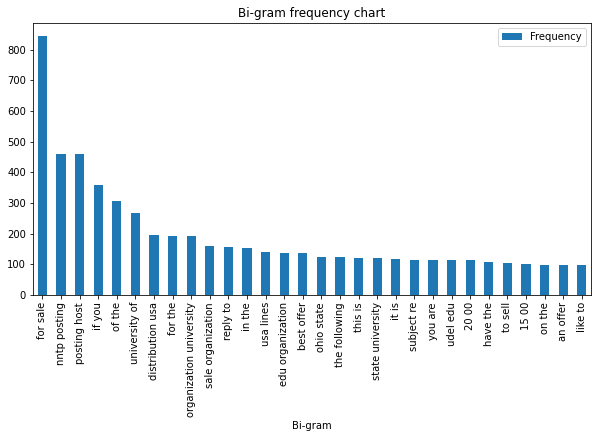

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Samples for the 'misc.forsale' category.
news_misc_forsale = []

# Iterate over all data.
for i in range(len(news.data)):
	# Get the samples.
	if news.target_names[news.target[i]] == 'misc.forsale':
		news_misc_forsale.append(news.data[i])

# Create the count vectorizer using bi-grams.
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform
x = vectorizer.fit_transform(news_misc_forsale)

# Get the 30 most frequent bigrams.
sum_words = x.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
words = words_freq[:30]

# Create and show the bar chart.
df = pd.DataFrame(words, columns=['Bi-gram', 'Frequency'])
df = df.set_index('Bi-gram')
df.plot(figsize=(10, 5), kind='bar', title='Bi-gram frequency chart')

## Dimensionality reduction

As part of the `EDA`, it can be helpful to visualize high-dimensional spaces in a way that our limited human brains can comprehend. This way, we can identify patterns in the data and possible directions for analysis. In this section, we will apply `dimensionality reduction` to visualize the samples in the _20 newsgroups_ dataset. Dimensionality reduction proves to be very helpful for speeding up the training of ML algorithms, filtering noise out of the data, performing feature extraction, and data visualization. 
Furthermore, working with fewer dimensions often makes the analysis more efficient and can help ML algorithms offer more accurate predictions.

### Principal Component Analysis

`Principal component analysis` (PCA) deals with unlabeled data, and for this reason, it is an unsupervised learning method. Contrary to supervised learning methods, PCA tries to identify relationships between the data samples without knowing the class each belongs to. The method creates a new coordinate system with a new set of orthogonal axes (principal components); the first axis goes toward the highest variance in the data, while the second one goes toward the second-highest variance.

Let’s programmatically calculate the first three principal components of different points. In the code that follows, we create the array with the points and standardize their values.

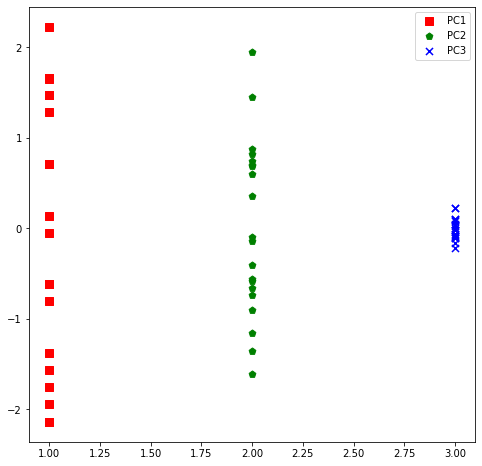

In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Our random data points.
points = np.array([[0.1,0.1,0.1], [0.2,0,0.2], [0.3,-0.1,0.3],
                    [0.4,-0.1,0.4], [-0.1,0.1,-0.1], [-0.2,0,-0.2],
                    [-0.3,0.1,-0.3], [-0.4,0,-0.4], [-0.5,0.1,-0.5],
                    [0.2,0,0.1], [0.3,0.1,0.2], [0.4,-0.1,0.5],
                    [0.5,0.1,0.4], [0.5,0,0.6], [0.3,-0.1,0.4],
                    [-0.2,-0.1,-0.1], [-0.4,0.1,-0.3], [-0.2,0.1,-0.3],
                    [-0.6,-0.1,-0.5], [-0.5,0,-0.4]])	
			
# Standardize the points.
spoints = StandardScaler().fit_transform(points)

# Calculate 3 principal components.
pca = PCA(n_components=3)
pcaComponents = pca.fit_transform(spoints)

# Generate the scatter plot.
x1 = [1]*20
x2 = [2]*20
x3 = [3]*20

# Plot the figure.
pcaFigure = plt.figure(figsize=(8, 8))
pcaAxes = pcaFigure.add_subplot(1, 1, 1) 
pcaAxes.scatter(x1, pcaComponents[:,0], s=50, c='r', marker="s", label='PC1')
pcaAxes.scatter(x2, pcaComponents[:,1], s=50, c='g', marker="p", label='PC2')
pcaAxes.scatter(x3, pcaComponents[:,2], s=50, c='b', marker="x", label='PC3')
plt.legend(loc='upper right')


The plot suggests that _PC1_ captures the most variation, followed by _PC2_ and _PC3_. 

But how can we quantify that the principle components have considered enough of the variance? How many components should be chosen in a particular problem? The answer is shown in the following code fragment.

In [19]:
# Show the variance ratio per principal component.
pca.explained_variance_ratio_

array([0.69943775, 0.29606821, 0.00449403])

We observe that the first component contains 69.9% of the variance, the second 29.6%, and the third 0.004%.

We are now ready to draw the plot of the previous data points on the new coordinate system using the following code.

C:\Users\tsouraki\AppData\Local\Temp/ipykernel_70388/1513673132.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pcaFigure.show()


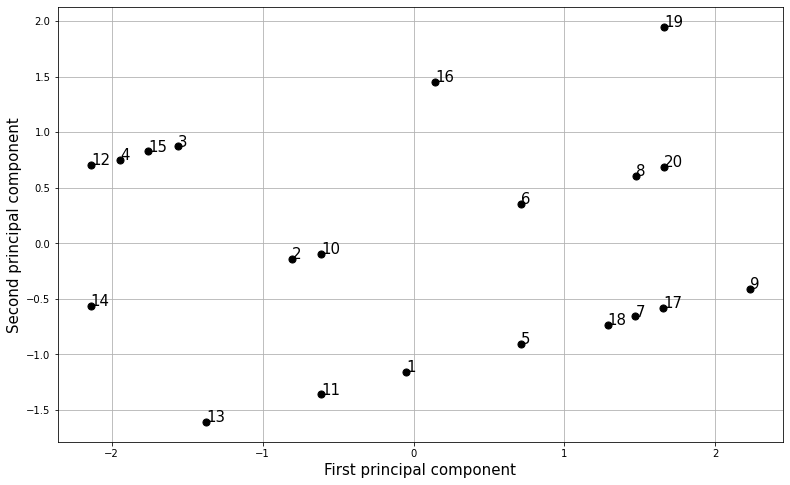

In [20]:
# Create a data frame out of the principal components.
pcaFrame = pd.DataFrame(data = pcaComponents, 
                        columns = ['principal component 1', 
                        'principal component 2', 'principal component 3'])
		
# Generate the scatter plot.	
pcaFigure = plt.figure(figsize=(13, 8))
pcaAxes = pcaFigure.add_subplot(1, 1, 1) 
pcaAxes.set_xlabel('First principal component', fontsize=15)
pcaAxes.set_ylabel('Second principal component', fontsize=15)

pcaAxes.scatter(pcaFrame.loc[:, 'principal component 1'],
                pcaFrame.loc[:, 'principal component 2'],
                c='black', s=50)

# Add the index of each point to the plot.
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
         11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
			   
for i, txt in enumerate(index):
    pcaAxes.annotate(txt, (pcaFrame.loc[i, 'principal component 1'],
                    pcaFrame.loc[i, 'principal component 2']), fontsize=15)

pcaAxes.grid()
pcaFigure.show()


The points now occupy a new position, with similar ones being closer than others. For example, look at the cluster with samples 3, 4, 12, and 15. 

### Linear Discriminant Analysis

`Linear discriminant analysis` (LDA) is the second dimensionality reduction technique used in this exercise. While PCA aims to identify the combination of principal components that maximize the variance in a dataset, LDA maximizes the separability between different classes by projecting the points onto a lower-dimensional space.

### PCA and LDA in action

Let’s apply our knowledge about PCA and LDA to the _20 newsgroups dataset_. In the following code, we extract a subset of the data for three specific news categories – _comp.sys.ibm.pc.hardware_, _comp.sys.mac.hardware_, and _talk.politics.misc_.

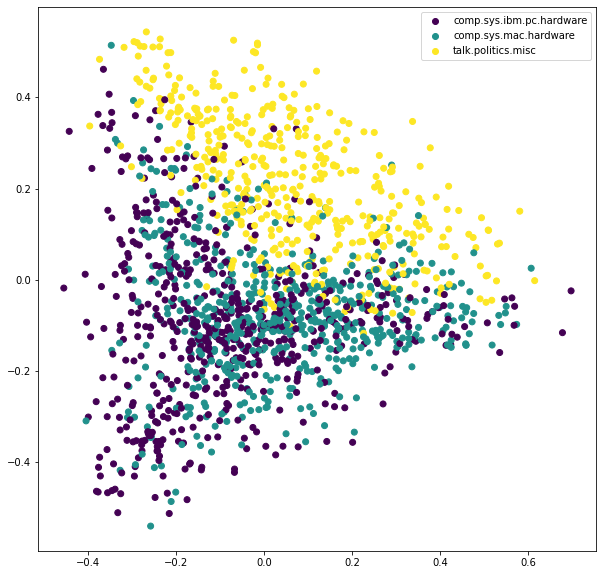

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Select one of the following three categories.
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'talk.politics.misc']
#categories = ['alt.atheism', 'comp.windows.x', 'talk.religion.misc']
#categories = ['rec.sport.baseball', 'rec.sport.hockey', 'sci.space']
#categories = ['rec.autos', 'rec.motorcycles', 'talk.politics.guns']

# Load the news data only for the specific categories.
news = fetch_20newsgroups(categories=categories)

# Keep a smaller portion of the data.
data_samples = news.data[:2000]
data_target = news.target[:2000]

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words='english')

# Generate the tf-idf matrix for the datamset.
tfidf = vectorizer.fit_transform(data_samples)
	
# Calculate 2 principal components.
pca = PCA(n_components=2)
pcaComponents = pca.fit_transform(tfidf.toarray())

# Create and show the plot.
plt.figure(figsize=(10, 10))
scatter = plt.scatter(pcaComponents[:,0], pcaComponents[:,1], c=data_target)
labels = np.unique(data_target)
handles = [plt.Line2D([],[], marker="o", ls="", color=scatter.cmap(scatter.norm(i))) for i in labels]
plt.legend(handles, categories)

The immediate observation is that the points of two topics appear to cluster closer together.

Let’s now incorporate LDA for the same task using two components again in the code that follows.

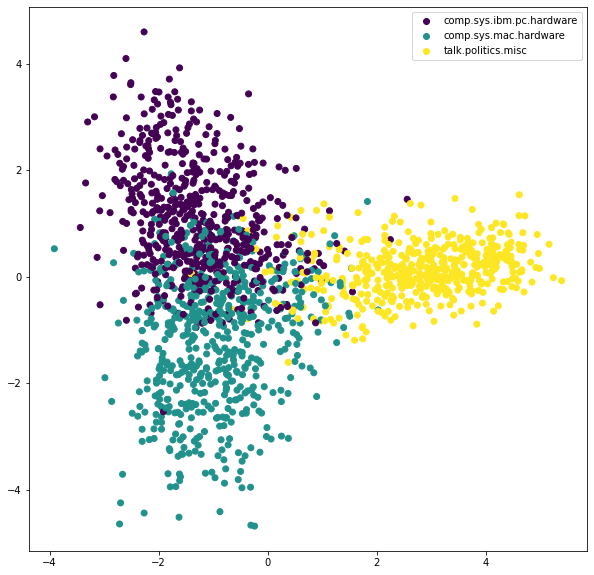

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Calculate 2 principal components.
lda = LinearDiscriminantAnalysis(n_components=2)
ldaComponents = lda.fit(tfidf.toarray(), data_target)
ldaComponents = lda.transform(tfidf.toarray())

# Create and show the plot.
plt.figure(figsize=(10, 10))
scatter = plt.scatter(ldaComponents[:,0], ldaComponents[:,1], c=data_target)
labels = np.unique(data_target)
handles = [plt.Line2D([], [], marker="o", ls="", color=scatter.cmap(scatter.norm(i))) for i in labels]
plt.legend(handles, categories)


The code that follows shows how to obtain the top ten words in each topic.

In [23]:
# Print the 10 top words per news category.
feature_names = np.asarray(vectorizer.get_feature_names())
for i, category in enumerate(categories):
    top = np.argsort(lda.coef_[i])[-10:]
    print("%s: %s" % (category, " ".join(feature_names[top])))

comp.sys.ibm.pc.hardware: os program card help ide bus pc dos windows host
comp.sys.mac.hardware: monitor ram work speed got software thanks apple mac nntp
talk.politics.misc: said say did people cramer writes stephanopoulos government clinton nntp


Observe output words such as **card**, **ide**, and **bus** for _comp.sys.ibm.pc.hardware_, **apple** and **mac** for _comp.sys.mac.hardware_, and **government** and **clinton** for _talk. politics.misc_.

## K-Nearest Neighbor

The `K-Nearest Neighbor` (KNN) is a non-parametric and lazy learning method that stores the position of all data samples and classifies new cases based on some similarity measure. Lazy learning means that the algorithm takes almost zero time to learn in this case. In the case of KNN, the training samples are stored and used to classify new observations based on a majority vote.

We restrict the analysis to five categories, as shown in the following code.

In [24]:
# Select the following five categories.
categories = ['alt.atheism', 'comp.graphics', 'misc.forsale', 'rec.autos', 'sci.crypt']
 
# Load data only for the specific categories.
train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=123)
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=123)

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(stop_words='english')

# Generate the tf-idf matrix for the two sets.
tfidf_train = vectorizer.fit_transform(train_data.data)
tfidf_test = vectorizer.transform(test_data.data)

# Print the shape of the sets.
print(tfidf_train.shape)

(2838, 39828)


Let’s now print the shape of the sets.

In [25]:
print(tfidf_test.shape)

(1890, 39828)


### Cross-validation

To use KNN, we need to choose a value for the hyperparameter _K_. The question now is what this value should be. Hopefully, there is a technique to help us in this situation that is called `Cross-Validation`. There are three basic steps: (1) initially, we partition the data into several subsets (folds), (2) each time we hold out one of these subsets and train the model with the rest, and (3) we evaluate the model with the holdout test. There are different types of cross-validation, and `k-Fold` is one of those. The code below shows an example of the 5-Fold cross-validation case.

In [26]:
import scipy.sparse as sp
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# List of possible number of neighbors.
neighbors_values = list(range(1, 100))

# List of the mean scores.
mean_scores = []

# Perform 10-fold cross-validation.
for n in neighbors_values:
    
    # Create the classifier.
    classifier = KNeighborsClassifier(n_neighbors=n)
    
    # Obtain the cross-validation scores.
    scores = cross_val_score(classifier, tfidf_train, train_data.target, cv=10, scoring='accuracy')
    
    # Store the mean value of the scores.
    mean_scores.append(scores.mean())
     
    # Calculate the errors.
    errors = [1 - x for x in mean_scores]
    
    # Obtain the best value for the hyperparameter.
    best_value = neighbors_values[errors.index(min(errors))]

# Print the best value for the hyperparameter.
print(best_value)

94


Using this value for _K=94_, we can now proceed to train the KNN model on the training set and evaluate it on test one.

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the classifier.
knn_classifier = KNeighborsClassifier(n_neighbors=94)

# Fit the classifier with the train data.
knn_classifier.fit(tfidf_train, train_data.target)

# Get the predicted classes.
test_class_pred = knn_classifier.predict(tfidf_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.9052910052910053

The accuracy is around 90.5%, which is quite a decent result. Next, we create and print the confusion matrix.

Text(0.5, 24.0, 'Predicted')

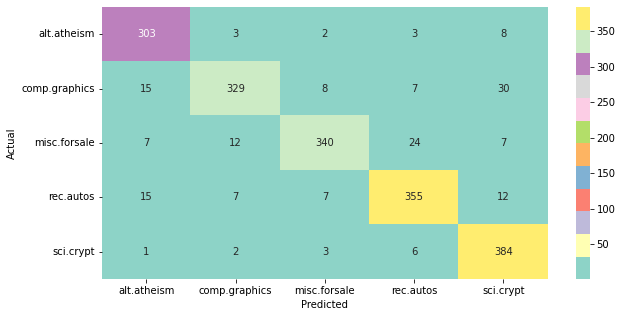

In [28]:
# Create the confusion matrix.
cm = confusion_matrix(test_data.target, test_class_pred)

# Plot confusion_matrix.
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(cm, annot=True, cmap="Set3", fmt="d", xticklabels=categories, yticklabels=categories)
ax.set_yticklabels(categories, rotation=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')

The confusion matrix provides a better analysis of the strengths and weaknesses of the model. Specifically, each row (or column) represents the instances in the actual class, while each column (or row) represents the instances in the predicted one. In the main diagonal, we quantify the number of samples for which the predicted label equals the actual one. In our case, 24 of the _misc.forsale_ posts are mistakenly classified as _rec.autos_ posts.

Next, we test the performance of KNN after removing any metadata from the samples in the dataset. The reason is to verify whether headers such as _From_ and _Subject_ impact the classification task.

In [29]:
# Load data only for the specific categories.
train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=123, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=123, remove=('headers', 'footers', 'quotes'))

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(stop_words='english')

# Generate the tf-idf matrix for the two sets.
tfidf_train = vectorizer.fit_transform(train_data.data)
tfidf_test = vectorizer.transform(test_data.data)

# Fit the classifier with the train data.
knn_classifier.fit(tfidf_train, train_data.target)

# Get the predicted classes.
test_class_pred = knn_classifier.predict(tfidf_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.20952380952380953

21% accuracy indicates a significant drop, and metadata eventually proves to be a valuable knowledge source for KNN. Perhaps specific keywords in the subject or the presence or absence of certain headers are critical factors for the efficiency of the KNN model.

### Baseline model

The following code shows the number of samples for the categories used in this section.

In [30]:
samples_per_category

{'rec.sport.hockey': 999,
 'comp.sys.ibm.pc.hardware': 982,
 'talk.politics.mideast': 940,
 'comp.sys.mac.hardware': 963,
 'sci.electronics': 984,
 'talk.religion.misc': 628,
 'sci.crypt': 991,
 'sci.med': 990,
 'alt.atheism': 799,
 'rec.motorcycles': 996,
 'rec.autos': 990,
 'comp.windows.x': 988,
 'comp.graphics': 973,
 'sci.space': 987,
 'talk.politics.guns': 910,
 'misc.forsale': 975,
 'rec.sport.baseball': 994,
 'talk.politics.misc': 775,
 'comp.os.ms-windows.misc': 985,
 'soc.religion.christian': 997}

The _sci.crypt_ category has the most samples, and we can get their number from the training and test sets respectively.

In [31]:
len(fetch_20newsgroups(subset='train', categories=['sci.crypt']).data)

595

In [32]:
len(fetch_20newsgroups(subset='test', categories=['sci.crypt']).data)

396

Based on the previous calculations, we decipher that 21% of the samples in the training set are from _sci.crypt_. If we assign this category to every sample in the test set, we are correct 20.9% of the time. The classifier that always predicts the majority category is called `ZeroR`, the simplest possible classifier.

## Random Forest

The `Random forest` method exploits the benefits of ensemble learning by constructing a multitude of `decision trees` on randomly selected data samples. Each decision tree produces its own prediction and the method is responsible for choosing the best result by voting.

In the code that follows, we create a random forests classifier and train it using the dataset without including the headers in each sample.

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Create the classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

# Fit the classifier with the train data.
rf_classifier.fit(tfidf_train, train_data.target)

# Get the predicted classes.
test_class_pred = rf_classifier.predict(tfidf_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.8

The accuracy reaches 80%, which is astonishingly better than the result obtained with the KNN classifier (21%).

Coming back to the discussion about dimensionality reduction, it makes sense to apply it to our classification problem. Instead of using all available features, we can try to introduce a smaller set of features. One common technique for this task is the `Singular Value Decomposition` (SVD), which efficiently works with sparse matrices (frequently encountered in text classification). 

Two hundred components are chosen as output for the SVD that will be used as features by the random forest classifier.

In [34]:
from sklearn.decomposition import TruncatedSVD

# Load data only for the specific categories.
train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=123)
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=123)

# Generate the tf-idf matrix for the two sets.
tfidf_train = vectorizer.fit_transform(train_data.data)
tfidf_test = vectorizer.transform(test_data.data)

# Calculate 200 components for the train and test sets.
svd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5, random_state=123, tol=0.0)

svdComponents_train = svd.fit_transform(tfidf_train.toarray())
svdComponents_test = svd.transform(tfidf_test.toarray())

print(svdComponents_train.shape)

(2838, 200)


We can also plot the percentage of the cumulative variance in a range of 1 to 200 components of SVD using the following code.

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

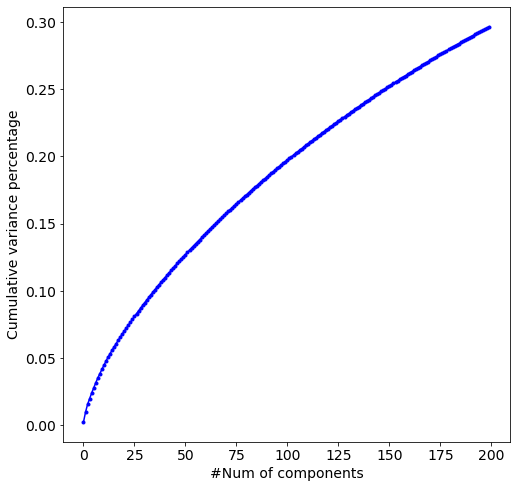

In [35]:
# Plot the cumulative variance percentage.
explained = svd.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 8))
plt.plot(explained, '.-', ms=6, color='b')
plt.xlabel('#Num of components', fontsize= 14)
plt.ylabel('Cumulative variance percentage', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

According to the figure, the 200 components capture around 30% of the variance in the dataset. Next, we create, train, and test the classifier.

In [36]:
# Fit the classifier with the train data.
rf_classifier.fit(svdComponents_train, train_data.target)

# Get the predicted classes.
test_class_pred = rf_classifier.predict(svdComponents_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.9047619047619048

The random forest classifier improves its performance and outputs an accuracy equal to 90% on the test set.

If we rerun the same code, using KNN and 10 components for SVD (_n_components=10_), the accuracy is again around 90%.

In [37]:
# Calculate 10 components for the train and test sets.
svd = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=123, tol=0.0)

svdComponents_train = svd.fit_transform(tfidf_train.toarray())
svdComponents_test = svd.transform(tfidf_test.toarray())

# Fit the classifier with the train data.
knn_classifier.fit(svdComponents_train, train_data.target)

# Get the predicted classes.
test_class_pred = knn_classifier.predict(svdComponents_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.891005291005291

This result is quite intriguing for two reasons. First, when we fed the same dataset (with no metadata), KNN failed to create an efficient model, as the accuracy was 21%. On the other hand, a much smaller representation with ten features provided the same performance as a model with 200 features.

## Word embedding

Suppose you are assigned to create the matching algorithm for a new dating service. This algorithm must identify people with similar characteristics and propose candidate profiles. Upon registering to the system, each user is asked a series of questions crafted to assess five personality traits. Based on their answer, each user receives a score (percentage) for each trait, which are included in a vector.

The code below calculates the cosine similarity between the user vectors. 

In [38]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Create the data for our user and the candidate profiles.
user = np.array([[0.41, 0.22, 0.85, 0.08, 0.98]])
candidates = np.matrix([[0.2, 0.93, 0.83, 0.39, 0.19],
                        [0.89, 0.87, 0.7, 0.18, 0.25],
                        [0.72, 0.03, 0.05, 0.82, 0.06],
                        [0.43, 0.78, 0.79, 0.02, 0.86],
                        [0.02, 0.03, 0.71, 0.39, 0.42]])

# Calculate and print the cosine similarity.
for candidate in candidates:
	print(cosine_similarity(user, candidate))

[[0.65631656]]
[[0.69953423]]
[[0.31021596]]
[[0.91916887]]
[[0.84170647]]


The fourth candidate has the highest cosine similarity with the user under study.

Now that you have grasped the reasoning behind the previous example, it should be straightforward to understand `word embeddings`. Just as the five traits represent each person as a unique point in a five-dimensional space, word embeddings represent words, typically in the realm of hundreds, in a multidimensional space. 

With the _gensim_ module, we can perform vector arithmetic using the pre-trained vectors model _GoogleNews-vectors-negative300.bin.gz_, which contains 3 million words and phrases. Notice that according to your system configuration, it might take several minutes to load and execute the code.

In [39]:
from gensim.models import KeyedVectors

# Load the Word2Vec model.
model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

# Perform various word vector arithmetics.
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.7118191123008728)]

In [40]:
model.most_similar(positive=['germany', 'paris'], negative=['france'], topn=1)

[('berlin', 0.48413652181625366)]

In [41]:
model.most_similar(positive=['play', 'walked'], negative=['walk'], topn=1)

[('played', 0.6983101963996887)]

In [42]:
model.most_similar(positive=['mother', 'doctor'], negative=['father'], topn=1)

[('nurse', 0.712788999080658)]

In [43]:
model.most_similar(positive=['she', 'architect'], negative=['he'], topn=1)

[('interior_designer', 0.6334888935089111)]

In [44]:
model.most_similar(positive=['woman', 'professor'], negative=['man'], topn=1)

[('associate_professor', 0.7771056294441223)]

In [45]:
model.most_similar(positive=['woman', 'schoolteacher'], negative=['man'], topn=1)

[('housewife', 0.6688467264175415)]

In [46]:
model.most_similar(positive=['woman', 'author'], negative=['man'], topn=1)

[('coauthor', 0.6184343695640564)]

In [47]:
model.most_similar(positive=['man', 'psychologist'], negative=['woman'], topn=1)

[('psychiatrist', 0.639894962310791)]

### Classification

Equipped with a good understanding of word embeddings, it’s about time to use them for classification. Using the same pre-trained vectors of the previous section, we calculate the embedding vector of each word in _sample_:

In [48]:
import re

def get_word_vector(sample):
 
    wv = np.zeros(300) # Word vector.
    n = 0 # Number of words that have a word vector.
    
    # Iterate over all words in the sample.
    for word in re.sub('\\(|\\)|\n|\t|  |,|\.|\?|/|=|\"', "", sample).split(" "):
        
        # The word might not be present in the model.
        if word.lower() in model:
            wv = np.add(wv, model[word.lower()])
            n += 1

    if n == 0: # Use a dummy word.
        wv = np.add(wv, model["empty"])
    else: # Get an average value by dividing with n.
        wv = np.divide(wv, n)

    return wv
        
def get_word_vect_from_data(input):

    # Word vectors of the samples.
    wv_vect = []

    # Iterate through the data.
    for sample in input:
    
        # Get the word vector.
        wv = get_word_vector(sample)

        # Store the result for the sample.
        wv_vect.append(wv)

    return wv_vect

# Get the word vectors for the training and test data.   
wv_train = get_word_vect_from_data(train_data.data)
wv_test = get_word_vect_from_data(test_data.data)

As before, we train and evaluate the random forest classifier.

In [49]:
# Fit the classifier with the train data.
rf_classifier.fit(wv_train, train_data.target)

# Get the predicted classes.
test_class_pred = rf_classifier.predict(wv_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.8222222222222222

This time, the performance is around 82%, less than we initially anticipated.

## fastText

Let’s examine a popular tool that off ers pre-trained word embedding models. [fastText](https://fasttext.cc/) is an open source tool created by Facebook for text representation and classification. The following code utilizes the same training and test set as before, which we restructure in the appropriate form.

In [50]:
import fasttext

# Read and clean the data.
fasttext_train_data = [re.sub('\\(|\\)|\n|\t|  |,|\.|\?|/|=|\"', "", sample) for sample in train_data.data]
fasttext_test_data = [re.sub('\\(|\\)|\n|\t|  |,|\.|\?|/|=|\"', "", sample) for sample in test_data.data]

# Read and change the class labels.
fasttext_train_target = [("__label__" + str(sample) + " ") for sample in train_data.target]
fasttext_test_target = [("__label__" + str(sample) + " ") for sample in test_data.target]

# Element wise concatenation of the two lists.
fasttext_train = [i + j for i, j in zip(fasttext_train_target, fasttext_train_data)] 

# Print a sample.
fasttext_train[0]

'__label__2 From: AGRGB@ASUACADBITNETSubject: Re: CDs priced for immediate saleArticle-ID: ASUACAD93096004253AGRGBOrganization: Arizona State UniversityLines: 10Hey nowThe following cds are still available Offerstrades consideredGowan - Lost BrotherhoodKatrina & the Waves - Break of HeartsJoe Cocker - LiveCharles Neville - DiversityThanksRich'

Now, we store the data and train the model. Then we extract the accuracy of the model.

In [51]:
# Write the data into a file.
with open('./data/fasttext.train', 'w') as f:
    for item in fasttext_train:
        f.write("%s\n" % item)
		
# Train the model.
fs_model = fasttext.train_supervised(input="./data/fasttext.train", lr=1.0, epoch=100)

# Get the predictions using the test data.
predictions = fs_model.predict(fasttext_test_data) 

# Assess the model.
fasttext_test_target_pred = [(label[0] + " ") for label in predictions[:][0]]
metrics.accuracy_score(fasttext_test_target, fasttext_test_target_pred)

0.8957671957671958

The fastText classifier yields an accuracy of around 90%, which is the same as the best model so far.

## What we have learned …

| | | |
| --- | --- | --- |
| **Exploratory data analysis**<ul><li>N-gram frequencies</li><li>Pie charts</li><li>Scatter plots</li><li>Heatmaps</li></ul> | **Dimensionality reduction**<ul><li>Principal Component Analysis</li><li>Linear Discriminant Analysis</li><li>Singular Value Decomposition</li></ul> | **ML algorithms & models**<ul><li>ZeroR</li><li>K-Nearest Neighbor</li><li>Random Forest</li><li>Decision Trees</li><li>Latent Dirichlet Allocation</li></ul> |
| **Text representations**<ul><li>Word2Vec</li></ul> | **ML concepts**<ul><li>Unsupervised learning</li><li>Cross-Validation</li></ul> | **Tools**<ul><li>fastText</li></ul> |
| | | |
